# Tehtävä 5: koneoppimisen ja syväoppimisen toteutus 

- Tässä dokumentissa keskitytään edellisten tulosten optimointiin ja tarkempaan analyysiin.

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
df = pd.read_csv("../data/base.csv", low_memory=False)


pd.options.display.max_columns = None


import warnings
warnings.filterwarnings('ignore')

In [115]:
# Muutetaan päivänmäärä pelkästään vuodeksi, koska scalerit eivät toimi datatimen kanssa
df["installation_date"] = pd.to_datetime(df['installation_date']).dt.year

df.shape

(602955, 30)

In [116]:
# Siivotaan datasta pois rivit missä hinta/DC suhde on alle 1000 tai yli 50000
df = df[(df["total_installed_price"] / df["system_size_DC"] >= 1000) & (df["total_installed_price"] / df["system_size_DC"] <= 50000)]

df.shape

(590744, 30)

### Luetaan aikaisemmin käsitelty dataframe ja muodostetaan siitä erilaiset versiot

In [117]:
# Otetaan mukaan residential-järjestelmät, missä ei ole akkua
res = df[(df['residential'] == 1) & (df['battery'] == 0)]
# Otetaan mukaan residential-järjestelmät, missä on akku
res_bat = df[(df['residential'] == 1) & (df['battery'] == 1)]

# Otetaan mukaan non_residential-järjestelmät, missä ei ole akkua
non_res = df[(df['residential'] == 0) & (df['battery'] == 0)]
# Otetaan mukaan non_residential-järjestelmät, missä on akku
non_res_bat = df[(df['residential'] == 0) & (df['battery'] == 1)]


res = res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
res_bat = res_bat.drop(columns=['battery', 'residential'])
non_res = non_res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
non_res_bat = non_res_bat.drop(columns=['battery', 'residential'])

### Tehtävään valitut algoritmit

-Regressiomallit kuvaavat yhteyttä syötemuuttujien ja valitun tarkasteltavan muuttujan välillä. Regressiomenetelmät kuten lineaariregressio  tuottavat vastaukseksi lukuarvon, jonka ei tarvitse olla kokonaisluku. Tästä syystä se sopii hyvin tässä projektissa esimerkiksi hinnan ennustamiseen. Kaikki tarkasteluun otetut algoritmit ovat regressiomalleja. Tavoitteena on ajaa testit valituille malleille ja löytää niistä lähtökohtaisesti 3 parasta mallia, ja tämän jälkeen hienosäätää valitut mallit mahdollisimman tehokkaiksi.

In [118]:
# Ladataan tarvittavia kirjastoja
from math import sqrt
from pandas import MultiIndex, Int16Dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

In [119]:
random_state = 42

# Tarkastelussa olevat algoritmit ja niille määritellyt default parametrit
models = {"RandomForest": RandomForestRegressor(random_state=random_state),
            "XGBoost": XGBRegressor(seed = random_state, tree_method="gpu_hist"),
            "CatBoost": CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False)
            }

In [120]:
# Alustetaan tarvittavia listoja
result_columns_list = ["Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"] 
scalers_list = ["None", StandardScaler(), RobustScaler(), MinMaxScaler()]

## Algoritmien vertailu

Rakennetaan funktio, jolle voi antaa parametrina eri datasettejä ja eri normalisointi funktiota. Funktio palauttaa dataframen missä on jokaiselle algoritmille laskettu arvot eri metriikoita käyttäen ja samalla piirretään kuvaaja, missä näkyy mielestämme mielenkiintoisin sarake eli 
ennustuksen Mean absolute error.

### Algoritmien paremmuuden määrittämiseen käytettiin seuraavia metriikoita: 

- RMSE = Root Mean Square Error. Keskineliövirheen neliöjuuri antaa normalisoidun etäisyyden ennustettujen arvojen vektorin ja pohjatotuutena olevan vektorin välillä. 
- R2 = R squared. R2-luku kertoo kuinka hyvin malli sovittuu regressiomalleissa opetusaineistoon. R2-luku kertoo kuinka suuren osuuden mallin muuttujat voivat selittää pohjatotuudesta.
- MAE = Mean absolute error.  Keskimääräinen absoluuttinen virhe antaa numeerisen arvon, joka kertoo kuinka paljon algoritmin tekemä arvio keskimäärin erosi pohjatotuudesta. 

In [121]:
def evaluate_models(df,scaler,models,importances=0):    


    # Jaetaan data treeni ja testi settiin 

    y = df["total_installed_price"]
    X = df.drop(columns="total_installed_price")

    features = X.columns

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 

    tulos = pd.DataFrame(columns=["Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"])
    
    # Skaalataan data funktiokutsussa ilmoitetulla skaalaajalla

    if scaler != "None":

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=features)        


    # Sovitetaan data mallille ja määritellään RMSE, R2 ja MAE testi- ja treeni-seteille ja tallennetaan ne dataframeen

    for name, model in models.items():
        

        model.fit(X_train,y_train)

        RMSE_test = sqrt(mean_squared_error(y_test, model.predict(X_test)))
        RMSE_train = sqrt(mean_squared_error(y_train, model.predict(X_train)))
        r2_test = r2_score(y_test, model.predict(X_test))
        r2_train = r2_score(y_train, model.predict(X_train))
        MAE_test = mean_absolute_error(y_test, model.predict(X_test))
        MAE_train = mean_absolute_error(y_train, model.predict(X_train))

        tulos.loc[len(tulos)] = [name,scaler,RMSE_train,RMSE_test,r2_train,r2_test,MAE_train,MAE_test]

    
        # Jos importances == 1 käsitellään dataframen feature_importances ja piirretään niistä kuvaajat
        if importances == 1:
            importances = model.feature_importances_
            sorted_importances = np.argsort(importances)[::-1]
            plt.figure(figsize=(20,20))
            plt.barh(X.columns[sorted_importances], importances[sorted_importances])
            plt.title(f"{name} Feature Importance")
            plt.show()
            tulos = ""
        
    
    return tulos

In [122]:
# Funktio, millä voidaan siivota poikkeamat pois datasetistä käyttäen IQR-menetelmää

def exception_handling(df, battery = 0):

    print("Alkuperäisen DataFramen koko = ",df.shape)

    # Käytetään akullisille jäjestelmille pienempää feature-listaa, koska muuten dataframe menee tyhjäksi!
    if battery == 1:

        features = ['system_size_DC', 'total_installed_price','inverter_loading_ratio', 'module_quantity','module_efficiency', 'inverter_total_capacity']
    else:
        features = ['system_size_DC', 'total_installed_price',        
                'inverter_loading_ratio', 'module_quantity','module_efficiency',
                'inverter_quantity', 'inverter_total_capacity']

    for col in features:

            alaraja, ylaraja = np.percentile(a=df[col], q=[25,75])
            iqr = ylaraja - alaraja
            #print((f"{col} Alaraja = {alaraja} Yläraja = {ylaraja} IQR = {iqr}"))

            # Tehdään uudet yla- ja alarajat missä mukana 1.5*IQR

            alaraja_iqr = alaraja - 1.5*iqr
            ylaraja_iqr = ylaraja + 1.5*iqr

            df = df[(df[col] > alaraja_iqr) & (df[col] < ylaraja_iqr)]
    
    print("Siivotun DataFramen koko = ",df.shape)        
    print("Keskihinta = ",df["total_installed_price"].mean())

    return df

In [123]:
# Funktio jolla voi piirtää kuvaajat dataseteistä

def draw_graph(df):

    df = df.sort_values("Model")

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title("Mean absolute error testset")
    sns.barplot(data=df,x ="Model", y="MAE test",hue="Scaler")
    plt.xticks(rotation=45,ha="right")
    plt.legend(loc='lower right')
    plt.subplot(1,2,2)
    plt.title("R2 score testset")
    sns.barplot(data=df,x ="Model", y="R2 test",hue="Scaler")
    plt.xticks(rotation=45,ha="right")
    plt.legend(loc='lower right')
    plt.show()


In [124]:
# Funktio, joka kutsuu aikaisemmat funktiot ja tulostaa tulokset

def print_results(df,models,scalers=scalers_list,result_columns=result_columns_list, battery=0, importances = 0):
    result_df = pd.DataFrame(columns=result_columns)

    # Siivotaan poikkeukset
    df_clean = exception_handling(df, battery)

    # Ajetaan eri skaalaajat evaluate_models funktion läpi
    for scaler in scalers:
        data = evaluate_models(df_clean,scaler,models, importances)
        result_df = result_df.append(data).sort_values(["R2 test","MAE test", "Model"],ascending=False)
        
    # Piirretään kuvaaja
    draw_graph(result_df)


    return result_df

In [125]:
# Funktio, jolla voi optimoida algoritmien hyperparamettereita

def hyperparameters_optimizer(df, model, param_grid, exceptions=0):

        # Siivotaan poikkeamat
        if exceptions == 0:
                df = exception_handling(df)
        
        y = df["total_installed_price"]
        X = df.drop(columns="total_installed_price")

        # Alustetaan RandomizedSearchCV
        grid = RandomizedSearchCV(
                model,
                param_grid,
                n_iter=25, scoring='neg_mean_squared_error', verbose=1)

        # Sovitetaan data RandomizedSearchCV funktiolle
        grid.fit(X,y)

        # Tulostetaan parhaat parametrit
        return grid.best_params_
    

# ----------------TODO---------------------


- Paljon analyysiä jokaisen kuvaajan jälkeen
- Syy minkä takia ajetaan kolmella algoritmilla ja 4 skalerilla ja vielä optimoiduilla arvoilla erikseen
    - paras skaler tuntuu olevan joka ajolla eri, ---> laita heittely väli analyyseihin
    - optimoidut arvot antavat mielenkiintoisia tuloksia non-optimoituihin verrattuna, esim sekottaa algoritmit ja skaalaajat  ---> analysoi näitä
- Feature importances kuvaaja parhaalle res datasetin ja skaalaajan tulokselle
    - poistetaan turhimmat sarakkeet ja ajetaan vielä 
        - kaikki läpi? / kaikki läpi samaan kuvaajaan? / paras algortimi + skaalaaja samaan kuvaajaan?

- Neuroverkon parannusta ---> koittaa saada vähintään sama tulos mitä koneoppimisesta
    - kattoa feature importance kuvaajaa neuroverkosta, jos pystyy, jos ei nii käyttää koneoppimisesta saatuja tuloksia?


## Akulliset residential kohteet
- Tässä setissä hinnan keskiarvo = 34546.66435248511
- Dataframen koko = 4416

Alkuperäisen DataFramen koko =  (6057, 28)
Siivotun DataFramen koko =  (4416, 28)
Keskihinta =  34552.197284873124


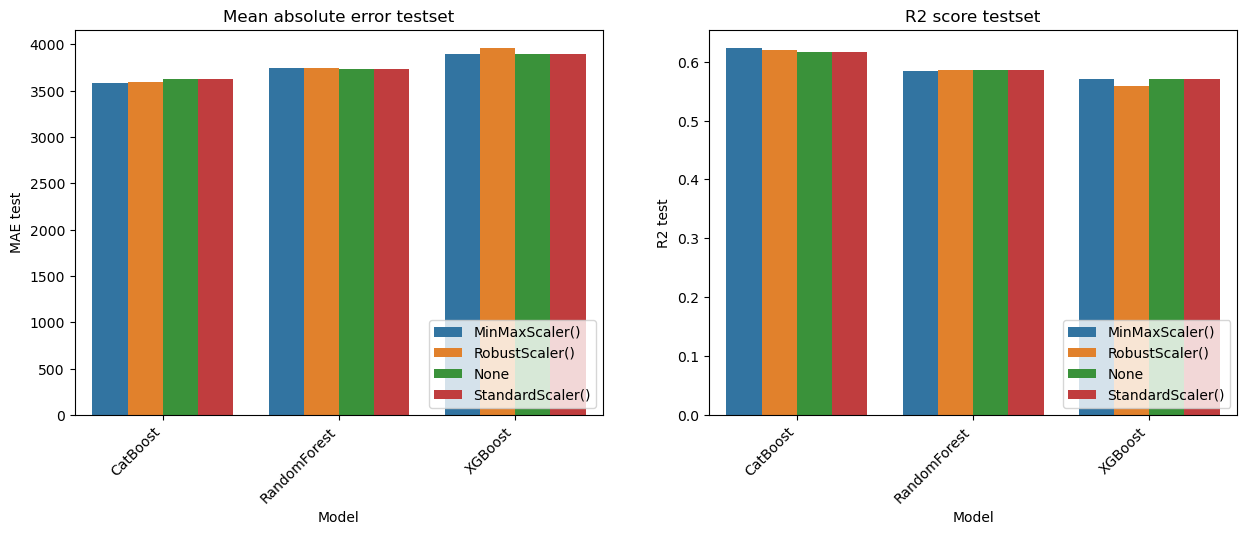

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,CatBoost,MinMaxScaler(),3310.607391,5676.138437,0.874833,0.623115,2284.151072,3581.035149
2,CatBoost,RobustScaler(),3328.831458,5697.540973,0.873451,0.620268,2289.284807,3589.866451
2,CatBoost,None,3366.071771,5729.322910,0.870603,0.616020,2316.333736,3623.078517
2,CatBoost,StandardScaler(),3366.071771,5729.802830,0.870603,0.615955,2316.333736,3623.779141
0,RandomForest,StandardScaler(),2378.053129,5948.509634,0.935417,0.586078,1497.145237,3734.741520
0,RandomForest,RobustScaler(),2378.844856,5949.806536,0.935374,0.585897,1497.447730,3740.889977
0,RandomForest,None,2379.412240,5950.450306,0.935343,0.585808,1497.536379,3735.962969
0,RandomForest,MinMaxScaler(),2382.343353,5955.515629,0.935184,0.585102,1499.298038,3741.150983
1,XGBoost,None,1721.912125,6055.552299,0.966139,0.571047,1145.472830,3900.304123
1,XGBoost,StandardScaler(),1721.912125,6055.552299,0.966139,0.571047,1145.472830,3900.304123


In [126]:
res_bat_result = print_results(res_bat, models, battery=1)
res_bat_result

In [127]:
res_bat_result.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,2486.241105,689.933214,1721.912125,1764.668718,2379.128548,3315.163407,3366.071771
RMSE test,12.0,5911.696948,161.413891,5676.138437,5729.682850,5950.128421,6055.552299,6136.619226
R2 train,12.0,0.924424,0.040567,0.870603,0.874487,0.935358,0.964430,0.966139
R2 test,12.0,0.590906,0.022231,0.559485,0.571047,0.585852,0.615971,0.623115
MAE train,12.0,1652.294657,501.209437,1145.472830,1181.558206,1497.492054,2285.434506,2316.333736
MAE test,12.0,3752.507706,134.187028,3581.035149,3623.603985,3738.426473,3900.304123,3958.675390


# UUDET ANALYYSIT

### Mietteitä ja huomioita akullisista residential systeemeistä

- Poikkeamien poistaminen laski MAE:n arvoa noin 2000:lla ja R2 scoressa oli myös pieniä parannuksia
- MAE heitti parhaimmillaan 3800 pohjatotuudesta, mikä keskiarvoon nähden ei ole huono, mutta ei myöskään loistava
- Kaikkien algoitmien R2 train oli huomattavasti parempi, mitä vastaava R2 test. Tästä voisi päätellä, että mallit ovat reippaasti ylioppineita

# Tähän ehkä vähän tarinaa CatBoostista?

### Käytössä olevien algoritmien määrän vähentäminen

Esikarsinnan tuloksena valikoitui 3 algoritmia: RandomForest, CatBoost, ja XGBoost Regressor. Kaikki näistä ovat päätöspuihin perustuvia algoritmeja. 
 
Päätöspuiden avulla pyritään kuvaamaan dataa puurakenteen avulla. Oksat kuvaavat datapisteestä tehtyjä havaintoja ja solmut johtopäätöksiä datapisteen siitä muuttujasta, jota päätöspuun avulla halutaan ennakoida. Gradienttitehostetut päätöspuut yhdistävät useita päätöspuita ennusteen tekemiseksi. Päätöspuut ovat tehokkaita käytettynä koneoppimisessa ja niitä voidaan käyttää monimutkaisiin aineistoihin ja ne sopivat myös regressiotehtäviin ,joten ne soveltuvat hyvin tähän projektiin.
 
Oikein säädettynä gradienttitehostetuiden puiden pitäisi suoriutua paremmin kuin satunnaismetsä(random forest tree). Tehostetut puut luovat yhden puun kerrallaan ja jokainen uusi puu yrittää parantaa edellisen puun suoritusta. Satunnaismetsä kouluttaa jokaisen puun itsenäisenä yksikkönä satunnaisella näytteellä datasta. Satunnaisuuden vuoksi mallissa ei tapahdu niin helposti ylioppimista.



### Hyperparametrien optimointi
Tehdään hyperparametrien optimointi käyttäen sklearnin RandomizedSearchCV algortimia.

# --------------------------ÄLÄ AJA SEURAAVAA KOLMEA-------------------------------------

- Pitääskö nämä poistaa.... tai ehkä muokata funktioksi tämäkin

In [ ]:

model = RandomForestRegressor(random_state=random_state)

# Määritellään kokeiltavat parametrit

param_grid = [
                {'bootstrap': [True, False],
                'max_depth': [3,6,7,9,10, 20, None],
                'max_features': ['auto', 'sqrt', None],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 4, 6],
                'n_estimators': [800, 1000, 1200, 1400, 1600, 1800, 2000]}
                ]

# Randomforest on käyteyistä algoritmeista kaikista hitain, joten optimoidaan se randomisti valitulla 50000 rivin otannalla
df_sample = exception_handling(res).sample(50000)
print("Sample df size = ", df_sample.shape)

hyperparameters_optimizer(df_sample, model, param_grid, exceptions=1)

In [ ]:
model = CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False)

param_grid = [
                {'depth':[3,1,2,6,4,5,7,8,9,10],
                'iterations':[250,100,500,1000],
                'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
                'l2_leaf_reg':[3,1,5,10,100],
                'border_count':[32,5,10,20,50,100,200],
                'subsample':[0.5, 0.7, 1.0]}
                ]

#hyperparameters_optimizer(res, model, param_grid)

In [ ]:
model = XGBRegressor(seed=random_state, tree_method="gpu_hist")

param_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

#hyperparameters_optimizer(res, model, param_grid)

#### optimointien tulokset:

- RandomForest: dataset = res.sample(50000), runtime= ??, runtime koko dataset yli 13h
    - {'n_estimators': 1800,
    - 'min_samples_split': 2,
    - 'min_samples_leaf': 2,
    - 'max_features': 'sqrt',
    - 'max_depth': 20,
    - 'bootstrap': False}

- CatBoostRegressor: dataset = res, runtime = n. 17min
    - {'subsample': 0.5,
    - 'learning_rate': 0.3,
    - 'l2_leaf_reg': 10,
    - 'iterations': 1000,
    - 'depth': 10,
    - 'border_count': 200}

- XGBRegressor: dataset = res, runtime = n. 3h
    - {'subsample': 0.8999999999999999,
    - 'n_estimators': 2000,
    - 'max_depth': 6,
    - 'learning_rate': 0.1,
    - 'colsample_bytree': 0.7,
    - 'colsample_bylevel': 0.8999999999999999}


Otetaan RandomizedSearchCV algoritmin ehdotukset käyttöön ja koitetaan ajaa vielä yksi testi samalla datasetillä

In [ ]:
models_tuned = {"RandomForest": RandomForestRegressor(n_estimators=1800,max_features='sqrt',max_depth=20,min_samples_leaf=2,min_samples_split=2,bootstrap=False, random_state=random_state),
            "CatBoost":CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False,subsample=0.5,learning_rate=0.3,l2_leaf_reg=10,iterations=1000,depth=10,border_count=200),
            "XGBoost Regressor": XGBRegressor(subsample=0.9,n_estimators=2000, max_depth=6,learning_rate=0.1,colsample_bytree= 0.7,colsample_bylevel=0.9,seed = random_state, tree_method="gpu_hist")           
            }

Ajetaan datasetti res_bat uudestaan optimoiduilla arvoilla

Alkuperäisen DataFramen koko =  (6057, 28)
Siivotun DataFramen koko =  (4416, 28)
Keskihinta =  34552.197284873124


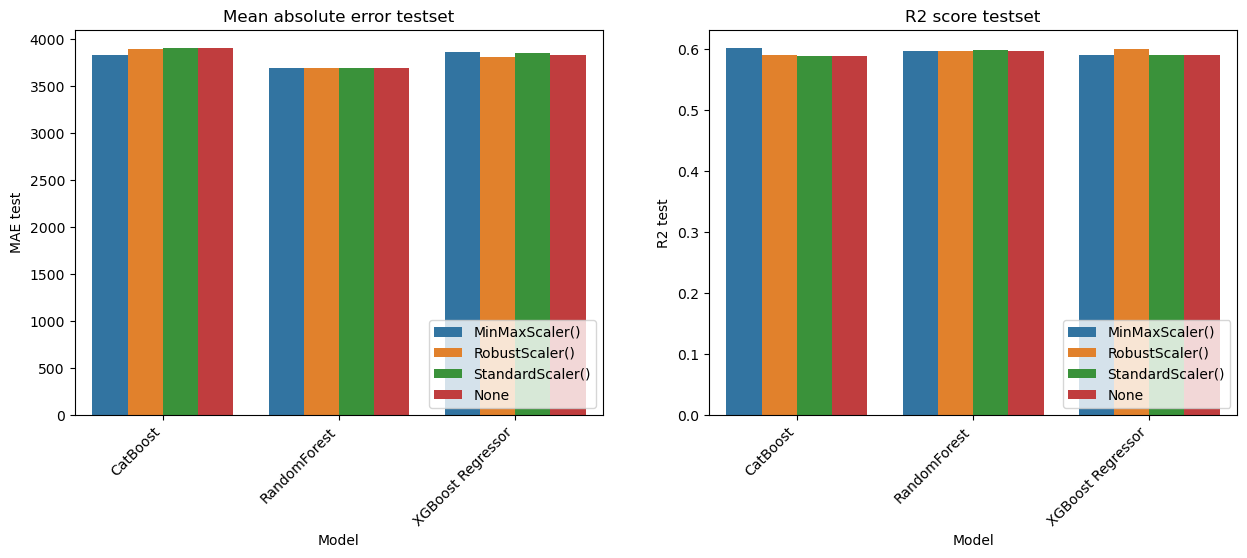

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
1,CatBoost,MinMaxScaler(),306.547798,5841.323133,0.998927,0.600860,152.191444,3826.433160
2,XGBoost Regressor,RobustScaler(),202.822028,5845.724527,0.999530,0.600259,27.731626,3804.319371
0,RandomForest,StandardScaler(),2272.701216,5867.649749,0.941012,0.597254,1451.156361,3687.130339
0,RandomForest,None,2272.477372,5868.888177,0.941024,0.597084,1451.140963,3688.468982
0,RandomForest,MinMaxScaler(),2272.612603,5869.525637,0.941017,0.596997,1451.347657,3688.964921
0,RandomForest,RobustScaler(),2271.305638,5871.851532,0.941085,0.596677,1450.647709,3690.562130
2,XGBoost Regressor,StandardScaler(),202.877846,5916.778096,0.999530,0.590482,28.075806,3850.188622
1,CatBoost,RobustScaler(),276.221284,5917.919229,0.999129,0.590324,126.415582,3894.793072
2,XGBoost Regressor,None,203.173823,5922.826457,0.999529,0.589644,29.110250,3825.510554
2,XGBoost Regressor,MinMaxScaler(),202.831174,5925.140638,0.999530,0.589324,27.727485,3856.126979


In [ ]:
res_bat_result_optimal = print_results(res_bat, models_tuned, battery=1)
res_bat_result_optimal

In [ ]:
res_bat_result_optimal.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,923.798489,996.734326,202.822028,203.099829,301.005546,2271.598571,2272.701216
RMSE test,12.0,5893.665839,36.073553,5841.323133,5868.578570,5894.314814,5923.405002,5938.422464
R2 train,12.0,0.979854,0.028671,0.941012,0.941070,0.998965,0.999529,0.999530
R2 test,12.0,0.593661,0.004972,0.587480,0.589564,0.593580,0.597127,0.600860
MAE train,12.0,540.914372,674.021092,27.727485,28.851639,147.713792,1450.771023,1451.347657
MAE test,12.0,3801.238088,88.401781,3687.130339,3690.162828,3825.971857,3865.793502,3901.545417


# UUDET ANALYYSIT


- Käyttämällä RandomizedSearchCV arvoja MAE testin arvot laskivat vielä noin 200-300.
- R2 train arvo tippu XGBoost regressorilla, mutta nousi Gradient Tree:llä. Randomforestilla pysyi melko samana
- R2 test arvot nousivat jokaisella algoritmillä, mikä on hyvä asia. Tosin ne vieläkin ovat 60% kieppeillä

## Non_residential kohteita sisältävä datasetti

-Seuraavaksi käsittelyssä non_res datasetti, mikä pitää sisällään kaikki non_residential kohteet.


Alkuperäisen DataFramen koko =  (11012, 27)
Siivotun DataFramen koko =  (6028, 27)
Keskihinta =  113145.6833012608


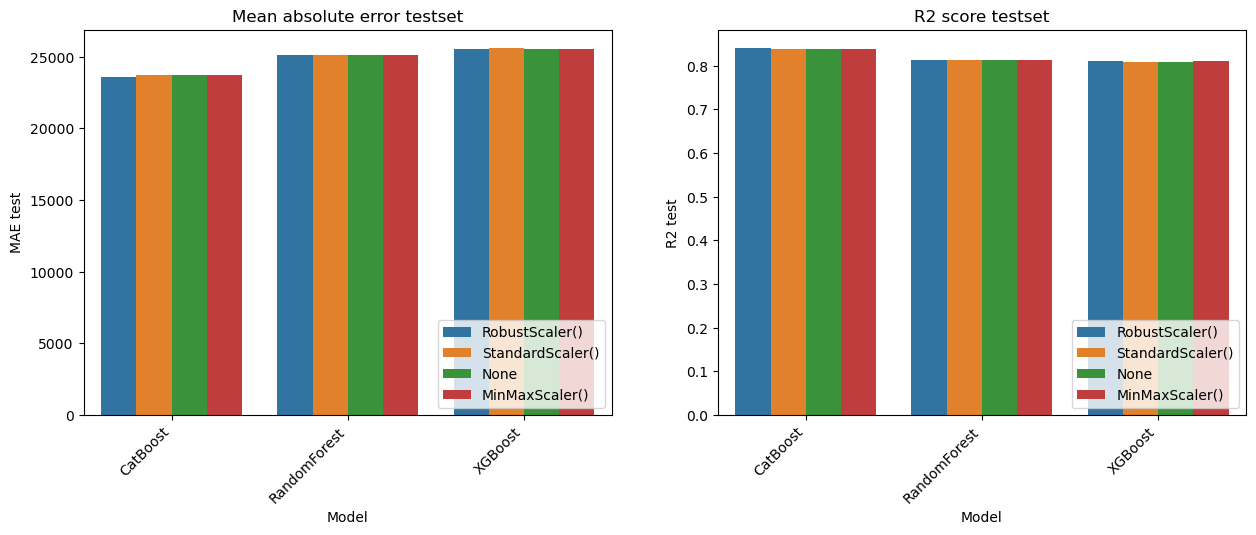

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,CatBoost,RobustScaler(),22818.646846,45245.886468,0.958769,0.839754,13878.567114,23573.450378
2,CatBoost,StandardScaler(),22647.511443,45438.727934,0.959385,0.838385,13733.008860,23689.431428
2,CatBoost,None,22647.511443,45439.104416,0.959385,0.838382,13733.008860,23690.626688
2,CatBoost,MinMaxScaler(),22689.284785,45459.079499,0.959235,0.838240,13738.955704,23697.108822
0,RandomForest,MinMaxScaler(),18072.006632,48898.045629,0.974138,0.812840,9582.205554,25087.079062
0,RandomForest,StandardScaler(),18079.899160,48964.070575,0.974115,0.812334,9574.547302,25132.314186
0,RandomForest,None,18064.924046,48964.719419,0.974158,0.812329,9560.939006,25102.278291
0,RandomForest,RobustScaler(),18089.516512,48967.450878,0.974088,0.812308,9601.958775,25124.603135
1,XGBoost,MinMaxScaler(),11831.952241,49355.776506,0.988914,0.809320,7414.504782,25552.716230
1,XGBoost,RobustScaler(),11831.952241,49359.345967,0.988914,0.809292,7414.504782,25561.928488


In [ ]:
non_res_result = print_results(non_res, models)
non_res_result

In [ ]:
non_res_result.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,17536.425819,4651.800355,11831.952241,11831.952241,18075.952896,22647.511443,22818.646846
RMSE test,12.0,47904.819479,1862.652520,45245.886468,45454.085728,48964.394997,49356.668871,49396.085953
R2 train,12.0,0.974077,0.012674,0.958769,0.959385,0.974127,0.988914,0.988914
R2 test,12.0,0.820117,0.013793,0.809008,0.809313,0.812332,0.838275,0.839754
MAE train,12.0,10255.100859,2756.130047,7414.504782,7414.504782,9578.376428,13733.008860,13878.567114
MAE test,12.0,24780.988349,849.325892,23573.450378,23695.488288,25113.440713,25555.019294,25593.652128


# VAATII LISÄÄ
#### Ajetaan non_res datasetti läpi optimoiduilla hyperparametereilla

Alkuperäisen DataFramen koko =  (11012, 27)
Siivotun DataFramen koko =  (6028, 27)
Keskihinta =  113145.6833012608


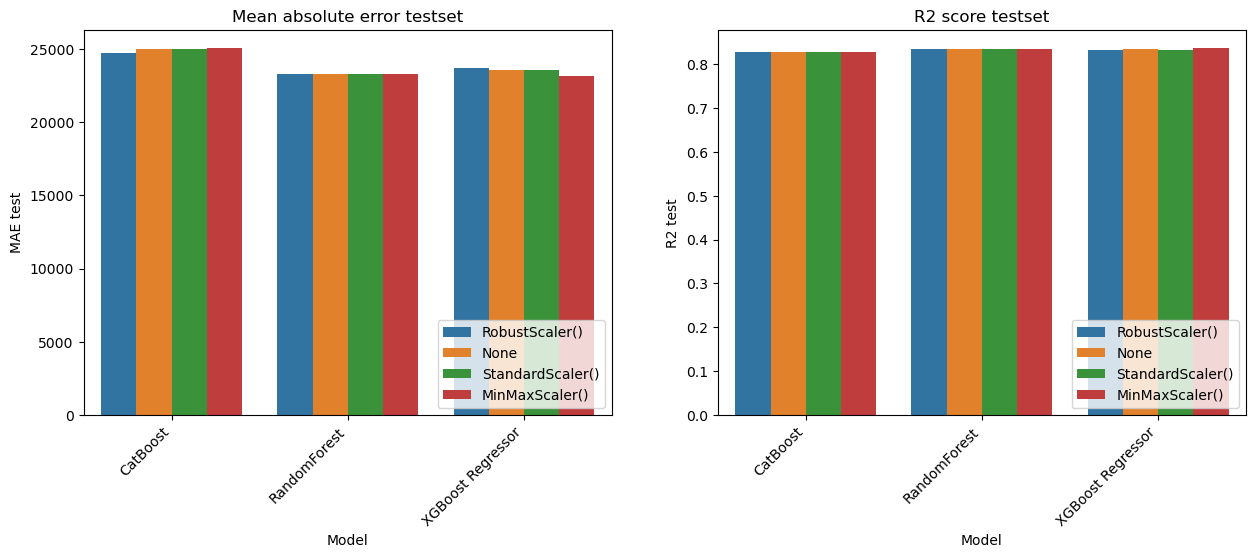

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,XGBoost Regressor,MinMaxScaler(),2790.413644,45712.653736,0.999383,0.836430,351.645559,23152.737803
0,RandomForest,StandardScaler(),15249.863073,45875.895380,0.981585,0.835260,6414.362026,23302.915610
0,RandomForest,MinMaxScaler(),15237.280344,45881.193427,0.981615,0.835222,6413.065652,23323.498018
0,RandomForest,RobustScaler(),15242.213736,45887.882295,0.981603,0.835174,6411.084400,23310.959668
0,RandomForest,None,15242.210701,45900.514095,0.981603,0.835083,6411.781376,23319.005722
2,XGBoost Regressor,None,2791.053005,46093.358731,0.999383,0.833694,353.907866,23558.502344
2,XGBoost Regressor,StandardScaler(),2791.260038,46138.424486,0.999383,0.833369,358.753548,23590.331618
2,XGBoost Regressor,RobustScaler(),2791.073798,46243.049696,0.999383,0.832612,356.050409,23684.762052
1,CatBoost,RobustScaler(),2879.626406,46764.686216,0.999343,0.828815,632.448062,24757.065188
1,CatBoost,None,2914.828101,46927.306710,0.999327,0.827622,708.923463,24988.587945


In [ ]:
non_res_result_optimized = print_results(non_res, models_tuned)
non_res_result_optimized

In [ ]:
non_res_result_optimized.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,6978.132951,6104.115313,2790.413644,2791.213478,2903.886281,15238.512933,15249.863073
RMSE test,12.0,46283.575147,492.097770,45712.653736,45886.210078,46115.891608,46805.341340,47045.879028
R2 train,12.0,0.993439,0.008743,0.981585,0.981612,0.999332,0.999383,0.999383
R2 test,12.0,0.832302,0.003575,0.826750,0.828517,0.833532,0.835186,0.836430
MAE train,12.0,2482.075226,2906.206233,351.645559,358.077764,686.440177,6411.258644,6414.362026
MAE test,12.0,23919.288150,775.982847,23152.737803,23316.994208,23574.416981,24814.945878,25054.425428


# KIRJOITA UUDET MIETTEET

### Mietteitä ja huomioita
- Poikkeamien pois ottaminen laski MAE:n arvoa noin 100000 ja samalla r2_test tulos nuosi noin 1 - 5 % algoritmista riippuen.
- Lopullinen MAE arvo oli noin 25000, joka keskiarvoon verrattuna on erittäin iso.
- Tässä setissä R2 train ja R2 test arvot olivat huomattavasti lähempänä toisiaan
- Myös R2 test arvot alkavat olemaan ylu 80%, joka alkaa tuntumaan jo ihan hyvältä arvolta


## Residential kohteita sisältävä dataset
- Tämä on tutkittavista dataseteistä suurin. Rivejä on vähän reilu 500000.

Alkuperäisen DataFramen koko =  (573527, 27)
Siivotun DataFramen koko =  (514586, 27)
Keskihinta =  24734.959499672048


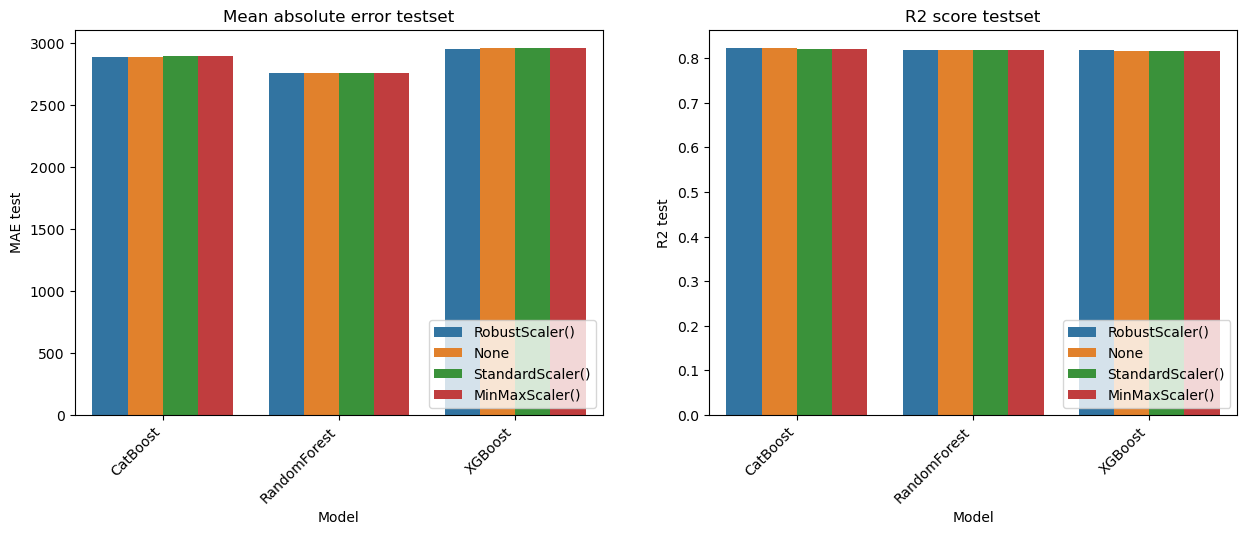

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,CatBoost,RobustScaler(),4450.359203,4544.760882,0.830091,0.822710,2833.138955,2884.687785
2,CatBoost,None,4451.984103,4547.494559,0.829967,0.822497,2831.889742,2884.874534
2,CatBoost,StandardScaler(),4461.295168,4556.061645,0.829255,0.821827,2839.034004,2892.814356
2,CatBoost,MinMaxScaler(),4464.408043,4561.856790,0.829016,0.821374,2843.081694,2897.311635
0,RandomForest,RobustScaler(),1722.914248,4588.612778,0.974534,0.819272,1030.197332,2759.071896
0,RandomForest,None,1723.797490,4588.872714,0.974508,0.819252,1030.531057,2758.555748
0,RandomForest,MinMaxScaler(),1723.705108,4589.277847,0.974511,0.819220,1030.207368,2758.671823
0,RandomForest,StandardScaler(),1723.501793,4589.888270,0.974517,0.819172,1030.506608,2759.737813
1,XGBoost,RobustScaler(),4437.166061,4600.243067,0.831097,0.818355,2863.563651,2948.318551
1,XGBoost,MinMaxScaler(),4444.276612,4615.541248,0.830555,0.817145,2864.000738,2957.454120


In [ ]:
res_result = print_results(res, models)
res_result

In [ ]:
res_result.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,3540.989383,1342.340316,1722.914248,1723.774395,4444.232285,4450.765428,4464.408043
RMSE test,12.0,4584.517348,26.161664,4544.760882,4560.408004,4589.075280,4604.067612,4616.053439
R2 train,12.0,0.878264,0.071090,0.829016,0.830060,0.830558,0.974509,0.974534
R2 test,12.0,0.819589,0.002057,0.817104,0.818052,0.819236,0.821487,0.822710
MAE train,12.0,2243.687948,896.180485,1030.197332,1030.524944,2836.086479,2863.672922,2864.102924
MAE test,12.0,2868.083375,85.343478,2758.555748,2759.571334,2888.844445,2950.602443,2958.038511


Alkuperäisen DataFramen koko =  (573527, 27)
Siivotun DataFramen koko =  (514586, 27)
Keskihinta =  24734.959499672048


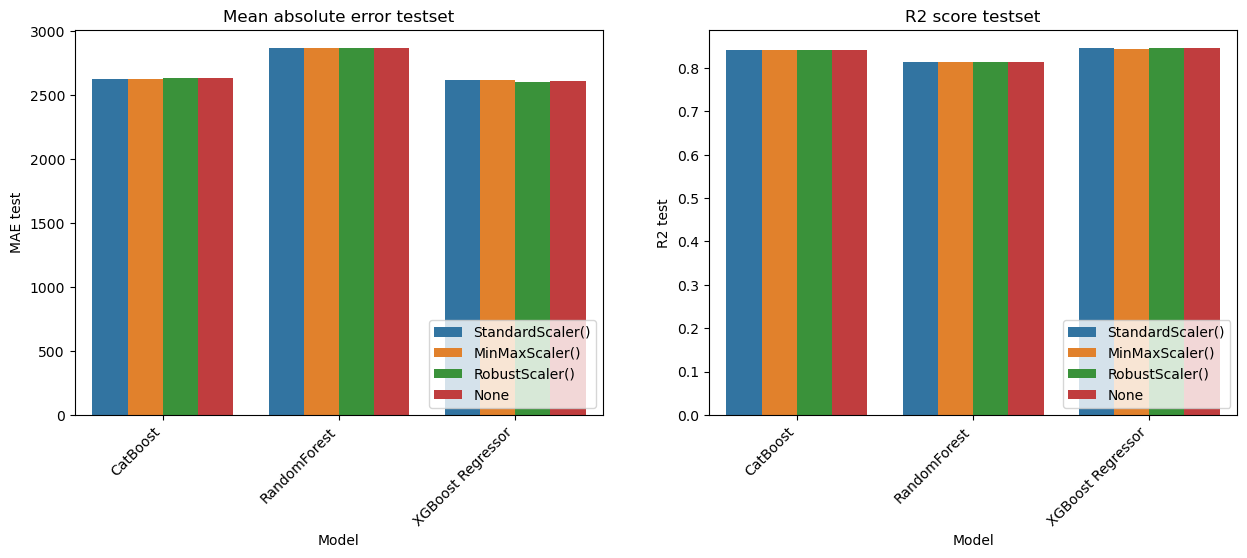

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,XGBoost Regressor,RobustScaler(),3582.590744,4239.278488,0.889891,0.845742,2247.089530,2605.578843
2,XGBoost Regressor,None,3587.730218,4243.144109,0.889575,0.845461,2252.860145,2609.882069
2,XGBoost Regressor,StandardScaler(),3585.141512,4248.554695,0.889735,0.845067,2251.915047,2615.277207
2,XGBoost Regressor,MinMaxScaler(),3591.983822,4249.435640,0.889313,0.845002,2255.928488,2614.613849
1,CatBoost,StandardScaler(),3454.016109,4285.310601,0.897653,0.842374,2151.636176,2627.572207
1,CatBoost,MinMaxScaler(),3462.746069,4286.016324,0.897135,0.842322,2157.303180,2627.516964
1,CatBoost,RobustScaler(),3467.454380,4290.027082,0.896855,0.842027,2163.379648,2635.440196
1,CatBoost,None,3484.382669,4294.229444,0.895845,0.841717,2171.764102,2633.817059
0,RandomForest,MinMaxScaler(),3189.772853,4645.852363,0.912714,0.814735,1951.681858,2865.423877
0,RandomForest,None,3191.672053,4646.288695,0.912610,0.814700,1953.005987,2866.231521


In [ ]:
res_result_optimized = print_results(res, models_tuned)
res_result_optimized

In [ ]:
res_result_optimized.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,3415.514575,172.558544,3189.772853,3194.626888,3465.100224,3583.228436,3591.983822
RMSE test,12.0,4393.448866,187.738133,4239.278488,4249.215404,4288.021703,4645.961446,4646.767157
R2 train,12.0,0.899688,0.010007,0.889313,0.889852,0.896995,0.912448,0.912714
R2 test,12.0,0.834041,0.014355,0.814662,0.814726,0.842175,0.845018,0.845742
MAE train,12.0,2122.104261,130.622520,1951.681858,1954.521540,2160.341414,2248.295909,2255.928488
MAE test,12.0,2702.824451,120.885698,2605.578843,2615.111367,2630.694633,2865.545706,2866.628423


# UUDET MIETTEET!!!

- Viimmeisenä ajettiin res_clean dataset mikä sisälti residential kohteet ilman akkuja. Tämä datasetti oli huomattavasti suurempi mitä kaksi edellistä. Kokoa tällä oli noin 500 000 riviä.
- Tässä datasetissä kirkkaasti parhaiten pärjäsi RandomForest.
- R2 arvot jättivät toivomisen varaa ollen parhaillaan 81% ja muuten 75-76%.
- Setin hinnan keskiarvoon 24299.369687 nähden, randomForestin MAE 2813 tuntuu melko hyvältä, tosin pienempi se voisi olla.


### Dataframen sarakkeiden optimointi

- Koska melkein kaikissa testeissä algoritmit olivat ylioppineita, koitetaan tätä ongelmaa parantaa vähentämällä ns."turhia" sarakkeita pois

Alkuperäisen DataFramen koko =  (573527, 27)
Siivotun DataFramen koko =  (514586, 27)
Keskihinta =  24734.959499672048


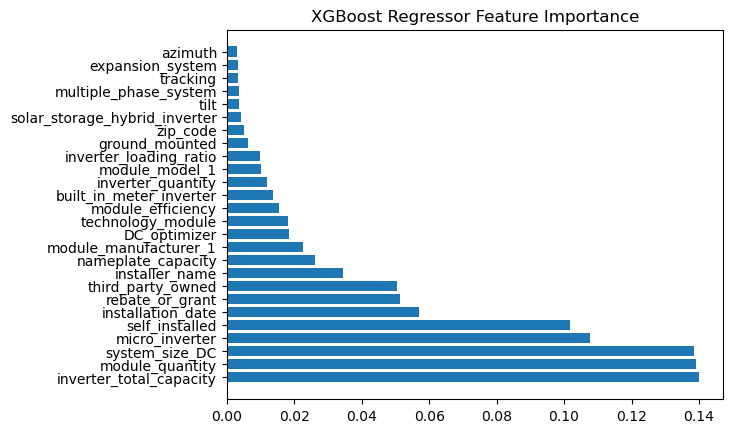

TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [ ]:
models_tuned = {"XGBoost Regressor": XGBRegressor(subsample=0.9,n_estimators=2000, max_depth=6,learning_rate=0.1,colsample_bytree= 0.7,colsample_bylevel=0.9,seed = random_state, tree_method="gpu_hist")}
scalers_list = [RobustScaler()]

#print_results(res, models_tuned, scalers=scalers_list, importances = 1)
#print_results(res, models_tuned,importances=1)

df_features = exception_handling(res)
evaluate_models(df_features,scalers_list,models_tuned,importances=1)

# Analyysiä featureista
- tiputetaan paskimmat pois
- ajetaan parhaalla algoritmilla/skalerilla vielä kaikki setit läpi

In [ ]:
# Pudotetaan valitut kolumnit pois

columns_clean = []

res_bat_feat_optimized = res_bat.drop(columns=[columns_clean])
non_res_feat_optimized = non_res.drop(columns=[columns_clean])
res_feat_optimized = res.drop(columns=[columns_clean])

df_feat_list = {"res_bat":res_bat_feat_optimized,"non_res": non_res_feat_optimized,"res": res_feat_optimized}
df_name_list = ["res_bat", "non_res", "res"]

result_columns_list_feat = ["DataFrame","Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"] 
scaler_best = [RobustScaler()]

result_feat_df = pd.DataFrame(columns=result_columns_list_feat)

for df_name, df_feat in df_feat_list.items():

    # Siivotaan poikkeukset
    df_feat_clean = exception_handling(df_feat)

    # Ajetaan eri skaalaajat evaluate_models funktion läpi

    data = evaluate_models(df_feat_clean,scaler_best,models_tuned)
    result_feat_df = result_feat_df.append(data).sort_values(["R2 test","MAE test", "Model"],ascending=False)
    result_feat_df["DataFrame"] = df_name


        
# Piirretään kuvaaja
draw_graph(result_feat_df)
result_feat_df

# PITÄÄSKÖ TÄHÄNKIN RUNOILLA JOTAIN


### Neuroverkko testi



In [ ]:
# import tensorflow as tf


# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, LearningRateScheduler

# tf.random.set_seed(42)

In [ ]:

neural_results = pd.DataFrame(columns=["Optimizer","Epochs", "Batch size", "RMSE Train", "RMSE Test", "MAE Train", "MAE Test"])

res_clean = exception_handling(res)

y = np.array(res_clean["total_installed_price"])
X = np.array(res_clean.drop(columns="total_installed_price"))


# Alustetaan omat skaalaajat x:n ja y:n arvoille
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# skaalataan arvot
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=random_state) 

shape_X = shape=X.shape[1]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Alkuperäisen DataFramen koko =  (573527, 27)
Siivotun DataFramen koko =  (514586, 27)
Keskihinta =  24734.959499672048
(344772, 26)
(169814, 26)
(344772, 1)
(169814, 1)


In [ ]:
# Tämä funktio laskee optimizerin learning ratea pikkuhiljaa epochien edetessä

def scheduler(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [ ]:
def deeplearning(model, optimizer, epochs, batch_size, callbacks=[],X_train = X_train, X_test=X_test, y_train=y_train,y_test=y_test, scaler_y=scaler_y):


    tulos = pd.DataFrame(columns=["Optimizer","Epochs", "Batch size", "RMSE Train", "RMSE Test", "MAE Train", "MAE Test"])

    model.compile(loss='mse', 
              optimizer=optimizer, 
              metrics=['mae'])


    #if len(callbacks) != 0:

    hist = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=epochs ,batch_size=batch_size ,verbose=0, callbacks=[callbacks])

    # Piirretään accuracy/loss kuvaaja
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['mae'])
    plt.plot(hist.history['val_mae'])
    plt.title('model accuracy')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


    # Ajetaan evaluate funktio train ja test seteille
    results_train = model.evaluate(X_train,y_train,batch_size=batch_size)
    results_test = model.evaluate(X_test,y_test,batch_size=batch_size)

    # Skaalataan arvot takaisin alkuperäiseen skaalaan
    scaled_train = scaler_y.inverse_transform([results_train])
    scaled_test = scaler_y.inverse_transform([results_test])

    rmse_train = scaled_train[0,0]
    rmse_test = scaled_test[0,0]
    mae_train = scaled_train[0,1]
    mae_test = scaled_test[0,1]

    tulos.loc[len(tulos)] = [optimizer, epochs, batch_size, rmse_train, rmse_test, mae_train, mae_test]


    return tulos

In [ ]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
learningrate = LearningRateScheduler(scheduler)

In [ ]:

model = Sequential()

model.add(Dense(64, input_dim=shape_X, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation="linear"))

model.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                1728      
                                                                 
 dense_53 (Dense)            (None, 128)               8320      
                                                                 
 dense_54 (Dense)            (None, 64)                8256      
                                                                 
 dense_55 (Dense)            (None, 32)                2080      
                                                                 
 dense_56 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20,417
Trainable params: 20,417
Non-trainable params: 0
_________________________________________________________________


Restoring model weights from the end of the best epoch: 62.
Epoch 72: early stopping


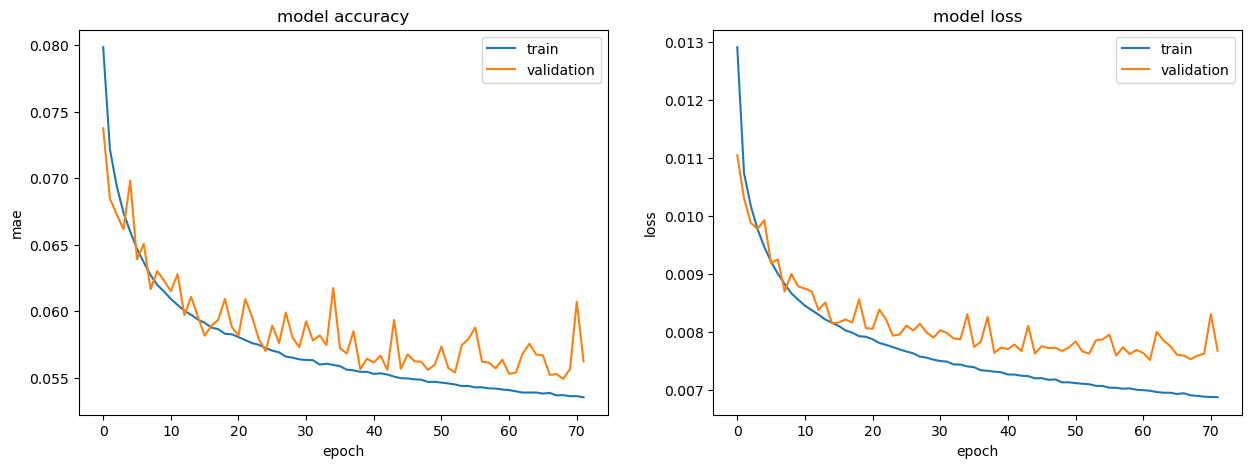

2654/2654 [==============================] - 5s 2ms/step - loss: 0.0074 - mae: 0.0552


,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test,Callbacks
0,<keras.optimizers.optimizer_v2.adam.Adam objec...,100,128,2726.193053,2725.096452,9353.459137,9351.909951,[<keras.callbacks.EarlyStopping object at 0x00...
0,<keras.optimizers.optimizer_v2.adam.Adam objec...,100,128,2726.193053,2725.096452,9353.459137,9351.909951,[<keras.callbacks.EarlyStopping object at 0x00...
0,<keras.optimizers.optimizer_v2.adam.Adam objec...,100,128,1356.725445,1355.573645,5126.707886,5127.177797,[<keras.callbacks.EarlyStopping object at 0x00...
0,Adam,100,64,1064.376647,1093.449075,3705.880398,3802.526598,NaN


In [ ]:
callback = [early]

data = deeplearning(model, "Adam", 100, 64, callbacks=callback)

neural_results = neural_results.append(data)

neural_results


### Verkko numero 2
- Lasketaan verkon koko käyttämällä kaavaa: ```Training Data Samples / (Factor * (Input Neurons + Output Neurons))```


In [ ]:
sample_size = X.shape[0]
factor = 1
io_neurons = X.shape[1] + 1

size = round(sample_size/(factor*io_neurons))


model = Sequential()

model.add(Dense(size, input_dim=shape_X, activation='relu'))
model.add(Dense(1, activation="linear"))

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 19059)             514593    
                                                                 
 dense_58 (Dense)            (None, 1)                 19060     
                                                                 
Total params: 533,653
Trainable params: 533,653
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = [early]

data = deeplearning(model, Adam(), 100, 128, callbacks=callback)

neural_results = neural_results.append(data)

neural_results

In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=X.shape[1],)))
# model.add(tf.keras.layers.Dense(30, activation="tanh"))

# model.add(tf.keras.layers.Dense(30, activation="tanh"))

# model.add(tf.keras.layers.Dense(30, activation="tanh"))

# model.add(tf.keras.layers'.Dense(1

# TÄNNE LISÄÄ TEKSTIÄ

### Neurovekko analyysiä
- Neuroverkko sai res_clean datasetin ajettua erittäin nopeaa läpi. Verrattuna Koneoppimisalgoritmeihin.
- Neuroverkossa arvojen skaalaamisella oli erittäin suuri vaikutus lopputulokseen. Mikä on luonnollista, koska eri neuronien väliset weight-arvot muuttuvat vähemmän.
- Viimmeisin neuroverkko sai MAE arvon 3653, mikä on samaa tasoa, mitä XGBoost ja Gradient Tree Boostingilla saadut MAE arvot ja huonompi mitä RandomForest
- RMSE = 5615.67503. Tämä on kanssa samaa suuruusluokkaa XGBoost ja Gradient Tree Boostingin kanssa ja huonompi mitä RandomForestilla.
- ROC kuvaajissa voidaan huomata, että Train Loss ja Accuracy pienenee melko jyrkästi, mutta validation loss ja accuracy poukkuoilee oudosti käyrän molemmilla puolilla, mikä ei ole optimaali tilanne. Tosin neuroverkkoa pitää vielä jatkokehittää.

In [ ]:
# Otetaan mallin painoarvot talteen
#model.save("models/model-v1.h5")

#### Jatkokehitysideoita

- Koska mallit tuntuivat olevan ylioppineita, siihen voisi mahdollisesti auttaa käytössä olevien sarakkeiden karsiminen, koska tällä hetkellä mukana on useita sarakkeita, jotka eivät hirveämmin vaikuta lopputulokseen